<a href="https://colab.research.google.com/github/ChaaruVijay/DSPL-CourseWork/blob/main/LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
#import necessary libraries
import pandas as pd
import numpy as np

In [17]:
# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Data Science/cleaned_traincsv (3).csv")

In [18]:
# Drop Customer_ID (not useful for prediction)
df_cleaned = df.drop(columns=['Customer_ID'])

In [19]:
# Define features and target
X = df_cleaned.drop(columns=['cluster_catgeory'])  # Features
y = df_cleaned['cluster_catgeory']  # Target variable

In [20]:
#check that the list of input variables
list(X)

['outlet_city', 'luxury_sales', 'fresh_sales', 'dry_sales']

In [21]:
#check that the list of target variable
y.head()

,cluster_catgeory
0,4.0
1,1.0
2,4.0
3,4.0
4,4.0


In [22]:
# Before creating LightGBM datasets, ensure labels are in the correct range
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the encoder to the target variable and transform it
y_encoded = label_encoder.fit_transform(y)

# use the encoded target variable for splitting and creating LightGBM datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=14, stratify=y_encoded)


# show the number of instances and input features in the training and test sets
print('X_train Instances', X_train.shape)
print('X_test Instances', X_test.shape)


X_train Instances (619226, 4)
X_test Instances (154807, 4)


In [23]:
from imblearn.over_sampling import SMOTE
# For handling imbalanced data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [24]:
# Create LightGBM dataset format
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [25]:
import lightgbm as lgb

# Optimized parameters
params = {
    "objective": "multiclass",
    "num_class": len(np.unique(y)),
    "metric": "multi_logloss",
    "boosting_type": "dart",
    "learning_rate": 0.05,
    "class_weight" : "balanced",
    "num_leaves": 15,
    "max_depth": 4,
    "min_data_in_leaf": 50,
    "feature_fraction": 0.6,
    "bagging_fraction": 0.6,
    "bagging_freq": 3,
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    "num_threads": 4,
    "device": "cpu",
    "early_stopping_rounds": 50
}

In [26]:
num_boost_round = 150  # Number of trees

# Train LightGBM with early stopping
model = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=num_boost_round,
    callbacks=[lgb.early_stopping(50, verbose=False)]
)

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 906990, number of used features: 4
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [27]:
# Make predictions for both train and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Convert probability outputs to class labels
y_train_pred_classes = [np.argmax(line) for line in y_train_pred]
y_test_pred_classes = [np.argmax(line) for line in y_test_pred]

In [28]:
from sklearn.metrics import accuracy_score, classification_report

# Calculate accuracy for train and test sets
train_accuracy = accuracy_score(y_train, y_train_pred_classes)
test_accuracy = accuracy_score(y_test, y_test_pred_classes)

# Print train and test accuracy
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_classes))


Train Accuracy: 0.9955
Test Accuracy: 0.9978
Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37791
           1       1.00      1.00      1.00     31007
           2       1.00      0.98      0.99      9778
           3       1.00      1.00      1.00     34485
           4       0.97      1.00      0.98      7905
           5       1.00      1.00      1.00     33841

    accuracy                           1.00    154807
   macro avg       0.99      0.99      0.99    154807
weighted avg       1.00      1.00      1.00    154807



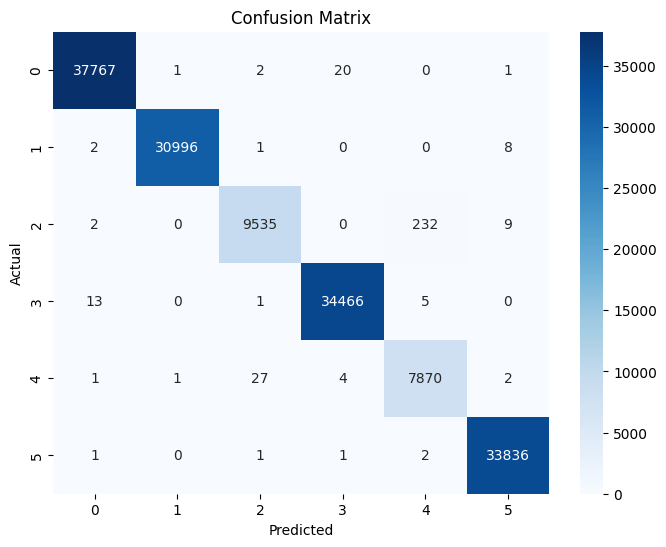

In [29]:
# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_test_pred_classes), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

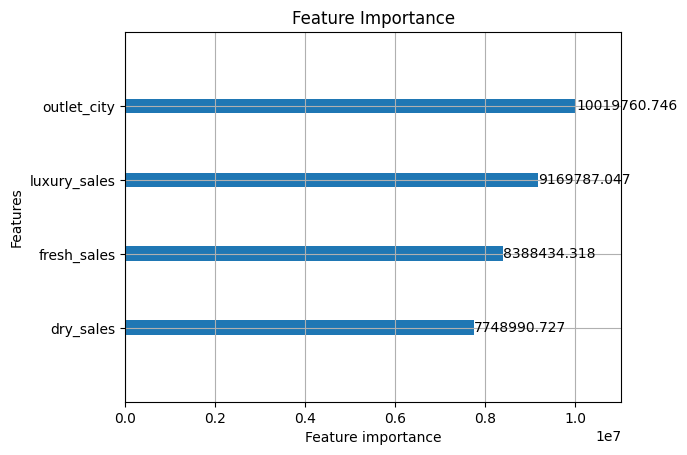

In [30]:
# Feature importance visualization
lgb.plot_importance(model, max_num_features=10, importance_type="gain")
plt.title("Feature Importance")
plt.show()

In [31]:
!pip install --upgrade lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 45.7 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.5.0
    Uninstalling lightgbm-4.5.0:
      Successfully uninstalled lightgbm-4.5.0


In [32]:
import lightgbm as lgb

# Dictionary to store training history
evals_result = {}


# Train LightGBM model and log loss values
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],  # Monitor both training & validation loss
    valid_names=["Train", "Validation"],
    num_boost_round=100,

    callbacks=[lgb.early_stopping(20, verbose=True), lgb.record_evaluation(evals_result)],
)


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 906990, number of used features: 4
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

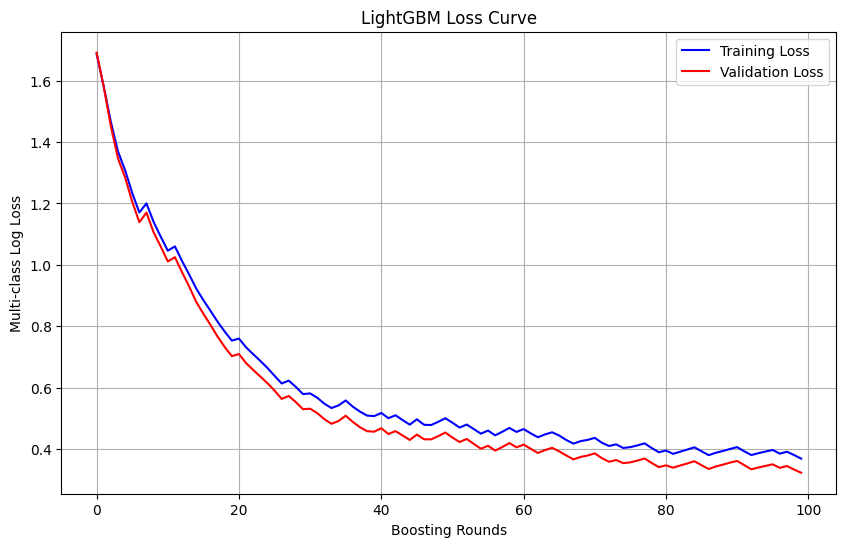

In [33]:
# Extract loss values
train_loss = evals_result["Train"]["multi_logloss"]
val_loss = evals_result["Validation"]["multi_logloss"]
epochs = range(len(train_loss))

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label="Training Loss", color="blue")
plt.plot(epochs, val_loss, label="Validation Loss", color="red")
plt.xlabel("Boosting Rounds")
plt.ylabel("Multi-class Log Loss")
plt.title("LightGBM Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

In [34]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Train LightGBM model
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=100,
    # Pass early stopping as a callback
    callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=True)]
)

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 906990, number of used features: 4
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

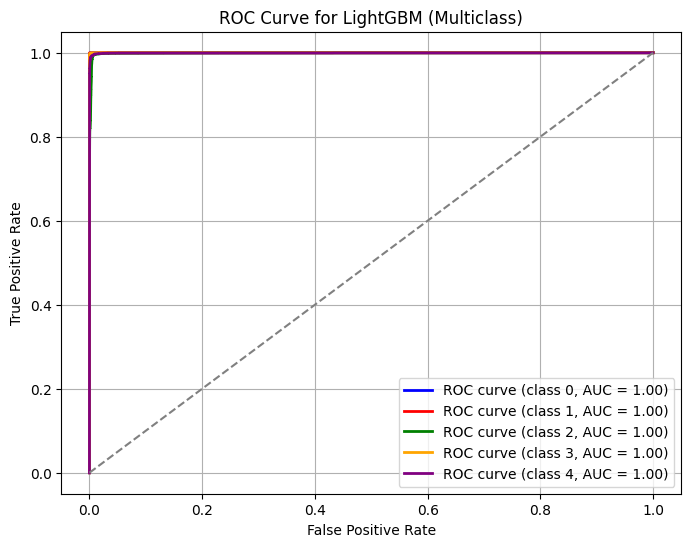

In [35]:
# Binarize the labels for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Get predicted probabilities for all classes
y_pred_prob = model.predict(X_test)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (class {i}, AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for LightGBM (Multiclass)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [36]:
import joblib

# Save the trained LightGBM model
joblib.dump(model, 'lightgbm_model.pkl')
print("\nModel saved successfully as 'lightgbm_model.pkl'")



Model saved successfully as 'lightgbm_model.pkl'


In [37]:
from google.colab import files
files.download('lightgbm_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Test LightGBM Model on Real World Data

In [38]:
# Load test dataset
import pickle
test_df = pd.read_csv("/content/drive/MyDrive/Data Science/cleaned_test.csv")

# Load the trained LightGBM model
model_path = "lightgbm_model.pkl"
with open(model_path, "rb") as model_file:
    model = pickle.load(model_file)

In [39]:
# Extract features (excluding Customer_ID)
X_test = test_df.drop(columns=["Customer_ID"])

In [40]:
import numpy as np
# Predict cluster categories
cluster_probabilities = model.predict(X_test)  # Get probabilities for each cluster
predicted_labels = np.argmax(cluster_probabilities, axis=1)  # Get predicted cluster labels

LightGBMError: The number of features in data (5) is not the same as it was in training data (4).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

In [ ]:
# Add predictions to the test data
test_data["Predicted_labels"] = predicted_labels

In [ ]:
# Choose essential columns for the output
output_data = test_data[["Customer_ID", "Predicted_Cluster"]]

In [ ]:
# Save predictions to a CSV file
output_file = "cluster_predictions.csv"
output_data.to_csv(output_file, index=False)

In [ ]:
from google.colab import files
files.download(output_file)
print("Predictions saved! Download 'cluster_predictions.csv'.")